AuxTel test LTS-337-027 (Auxiliary Telescope Dome Rotation Requirement)

Specification: None of the upgrades or modifications of the Auxiliary telescope shall degrade its total image quality. The total telescope image quality degradation shall not exceed the existing telescope system image quality value Aux_Tel_Tel_IQ at any point in the central 5 by 5 arcminutes of the field of view. The image quality shall be measured over a 5 minute guided exposure.

Discussion: The overall image quality budget 0.35"FWHM to the Auxiliary Telescope median delivered PSF. 

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The Auxiliary Telescope shall deliver this image quality contribution to the median delivered PSF: | 0.35       | ArcsecFWHM   |Aux_Tel_Tel_IQ|


This notebook is divided into 6 sections:
1. Notebook setup
2. 75 degree elevation IQ
3. 35 degree elevation IQ
7. Conclusion. 

# Notebook setup 

In [1]:
import numpy as np
from astropy import units as u
import pandas as pd

from matplotlib import pyplot as plt
from datetime import datetime, date
from astropy.time import Time, TimeDelta

import lsst.daf.butler as dafButler
from lsst.summit.utils import BestEffortIsr
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfConfig
from lsst.pex.exceptions import InvalidParameterError
from lsst.ts.observatory.control.constants import latiss_constants
from lsst.geom import PointD
# below is an unused import, but is required to use the `psfex` fitter
import lsst.meas.extensions.psfex.psfexPsfDeterminer # noqa: F401

%matplotlib inline

In [2]:
# Enter the filename where to save the results.
filename = 'IQ' + date.today().strftime("%y%m%d") + '.txt'
print(filename)

IQ221017.txt


#### Declare butler repo parameters

In [3]:
datapath='/repo/LATISS'
butler = dafButler.Butler(datapath, instrument='LATISS', collections=['LATISS/raw/all','LATISS_test_data'])
dataset='raw'
best_effort_isr = BestEffortIsr()

# Calculate Stellar PSF Information

### Declare the function that does the heavy lifting using DM tools
Note that this is very sensitive to the number of sources in the field. <br>
If there are not enough sources this will fail.

In [4]:
def measurePsf(exp):
    platescale = latiss_constants.pixel_scale

    imCharConfig = CharacterizeImageTask.ConfigClass()
    imCharConfig.doMeasurePsf = True
    imCharConfig.useSimplePsf = True
    
    imCharConfig.doApCorr = False
    imCharConfig.doDeblend = False
    
    installConfig = InstallGaussianPsfConfig()
    exp.setPsf(None)  # if not set to none, fwhm max para is ignored
    installConfig.fwhm = 15
    installConfig.width = 61
    
    imCharConfig.installSimplePsf = installConfig    
    
    imCharConfig.detection.includeThresholdMultiplier = 5
    imCharConfig.measurePsf.starSelector['objectSize'].doFluxLimit = True
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMin = 12500.0
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].doSignalToNoiseLimit = False
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMin = 20.0
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMin = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMax = 80.0  # default 10
    imCharConfig.measurePsf.starSelector['objectSize'].sourceFluxField = "base_GaussianFlux_instFlux"
    imCharConfig.measurePsf.starSelector['objectSize'].widthStdAllowed = 0.15 # 0.15 default
    imCharConfig.measurePsf.starSelector['objectSize'].nSigmaClip = 2.0
    
    imCharConfig.measurePsf.psfDeterminer.name = 'psfex'
    imCharConfig.measurePsf.psfDeterminer['psfex'].spatialOrder = 1
    imCharConfig.psfIterations=1
    
    imCharConfig.background.binSize = 2000
    imCharConfig.background.approxOrderX = 2

    imCharConfig.detection.background = imCharConfig.background
    
    imCharTask = CharacterizeImageTask(config=imCharConfig)

    result = imCharTask.run(exp)

    psf = exp.getPsf()
    ixx = psf.computeShape(exp.getBBox().getCenter()).getIxx()
    iyy = psf.computeShape(exp.getBBox().getCenter()).getIyy()
    psfShape = psf.computeShape(exp.getBBox().getCenter()).getDeterminantRadius()
    
    fwhmX = np.sqrt(ixx)*2.355*platescale
    fwhmY = np.sqrt(iyy)*2.355*platescale
    
    overallFwhm = psfShape * 2.355 * platescale
    print(f"Psf shape from imChar task (x,y) = ({fwhmX:.3f}, {fwhmY:.3f}) FWHM arcsec")
    return fwhmX, fwhmY, overallFwhm, psf

### Declare QuickFrameMeasurement tasks
These are run if the measurePsf method fails. It provides a reasonable yet less-accurate representation.

In [5]:
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

In [7]:
dataId = {'day_obs': 20221012, 'seq_num': 567, 'detector': 0, "instrument": 'LATISS'}
print(dataId)
best_effort_isr.doWrite = False  # Don't write to butler database
exp = best_effort_isr.getExposure(dataId, skipCosmics=False)
    

{'day_obs': 20221013, 'seq_num': 567, 'detector': 0, 'instrument': 'LATISS'}


### Select the data ID of choice

In [ ]:
fwhmX=None; fwhmY=None; overallFwhm=None
result=None
psf=None
success=False
line=[]

for i in np.arange(590, 1220, dtype=int):
    dataId = {'day_obs': 20221012, 'seq_num': i.item(), 'detector': 0, "instrument": 'LATISS'}
    print(dataId)
    best_effort_isr.doWrite = False  # Don't write to butler database
    exp = best_effort_isr.getExposure(dataId, skipCosmics=False)
    
    # Run the methods to get the psf data
    try:
        fwhmX, fwhmY, overallFwhm, psf = measurePsf(exp)
        success=True
        pass
    except InvalidParameterError as e:
        print('Caught the InvalidParameterError, measurePsf was not successful')
        pass
    except RuntimeError as e:
        print('Caught the RuntimeError, measurePsf was not successful')
        pass

    if not success:
        print('Using Merlin\'s simplified algorithm')
        exp = best_effort_isr.getExposure(dataId, skipCosmics=False)
        result = qm.run(exp)
        if result.success:
            fwhmX=result.medianXxYy[0]
            fwhmY=result.medianXxYy[1]
            overallFwhm=np.sqrt(result.medianXxYy[0]**2 + result.medianXxYy[1]**2)
        else:
            raise RuntimeError('No PSF could be derived using either method')
    
    
    # Derive corrections for airmass and wavelength
    filter_band=exp.getInfo().getFilterLabel().bandLabel 
    airmass=exp.getInfo().getMetadata().get('AMSTART')#+exp.getInfo().getMetadata().get('AMEND'))/2.0)
    elevation=exp.getInfo().getMetadata().get('ELSTART')#+exp.getInfo().getMetadata().get('ELEND'))/2.0)
    dimm_seeing=exp.getInfo().getMetadata().get('SEEING')
    
    date = exp.getMetadata().get("DATE")
    #airmass_corr_fwhm = overallFwhm * (airmass ** -0.6)
    
    airmass_corr_dimm_seeing = dimm_seeing * (airmass ** 0.6)

    
    filter_wavelength= {'white': 700, 'g': 475, 'r': 623, 'i': 763, 'z': 828.0}
    corr_dimm_seeing = airmass_corr_dimm_seeing * ((500. / filter_wavelength[filter_band]) ** 0.2)

    
    # Build each PD entry 
    line.append(
        {'exposure': i,
         'DateTime': date,
         'fwhmX': fwhmX,
         'fwhmY': fwhmY, 
         'overallFwhm':overallFwhm,  
         'airmass': airmass,
         'filter_band' : filter_band,
         'corr_dimm_seeing': corr_dimm_seeing,
        }
    )
    
df = pd.DataFrame(line)   

{'day_obs': 20221012, 'seq_num': 590, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (1.065, 1.009) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 591, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.234, 1.119) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 592, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.211, 1.108) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 593, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.024, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 594, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.036, 1.010) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 595, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.132, 1.093) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 596, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.185, 1.161) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 597, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.297, 1.178) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 598, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.309, 1.179) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 599, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.211, 1.099) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 600, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.199, 1.209) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 601, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.122, 1.167) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 602, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.143, 1.085) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 603, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.276, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 604, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.317, 1.113) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 605, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.171, 1.108) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 606, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.193, 1.128) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 607, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.116, 1.108) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 608, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.119, 1.039) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 609, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.328, 1.201) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 610, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.343, 1.163) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 611, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.112, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 612, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.107, 1.056) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 613, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.087, 1.070) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 614, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.144, 1.166) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 615, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.300, 1.089) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 616, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.328, 1.153) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 617, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.136, 1.075) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 618, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.122, 1.073) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 619, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.095, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 620, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.129, 1.089) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 621, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.349, 1.185) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 622, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.304, 1.150) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 623, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.209, 1.103) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 624, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.209, 1.143) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 625, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.229, 1.157) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 626, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.198, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 627, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.356, 1.208) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 628, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.311, 1.130) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 629, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.215, 1.150) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 630, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.209, 1.186) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 631, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.242, 1.198) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 632, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.226, 1.177) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 633, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.437, 1.297) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 634, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.510, 1.408) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 635, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.216, 1.154) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 636, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.277, 1.220) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 637, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.207, 1.199) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 638, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.153, 1.111) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 639, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.358, 1.189) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 640, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.349, 1.189) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 641, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.130, 1.143) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 642, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.132, 1.099) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 643, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.206, 1.076) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 644, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.176, 1.074) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 645, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.394, 1.210) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 646, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.364, 1.255) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 647, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.211, 1.182) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 648, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.192, 1.118) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 649, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.107, 1.054) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 650, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.130, 1.138) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 651, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.227, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 652, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.299, 1.119) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 653, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.404, 1.051) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 654, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.077, 0.929) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 655, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.048, 0.989) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 656, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.023, 1.010) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 657, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.303, 1.150) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 658, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.346, 1.180) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 659, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.108, 1.080) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 660, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.120, 1.058) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 661, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.097, 1.109) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 662, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.189, 1.078) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 663, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.281, 1.153) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 664, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.273, 1.147) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 665, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.080, 1.042) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 666, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.016, 0.928) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 667, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.247, 1.018) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 668, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.040, 1.027) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 669, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.323, 1.163) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 670, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.287, 1.109) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 671, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.088, 0.989) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 672, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.086, 0.994) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 673, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 674, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 675, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 676, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 677, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.139, 1.110) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 678, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.137, 1.062) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 679, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.147, 1.059) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 680, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.296, 1.160) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 681, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.267, 1.086) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 682, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.291, 1.141) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 683, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.316, 1.193) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 684, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.116, 1.053) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 685, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.096, 1.047) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 686, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.181, 1.126) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 687, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.174, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 688, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.118, 1.104) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 689, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.226, 1.175) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 690, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.262, 1.148) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 691, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.318, 1.151) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 692, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.034, 0.981) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 693, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.027, 0.993) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 694, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.041, 0.992) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 695, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.057, 0.983) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 696, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.277, 1.102) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 697, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.258, 1.106) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 698, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.012, 0.997) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 699, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.057, 1.003) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 700, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.232, 1.088) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 701, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.083, 0.990) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 702, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.278, 1.073) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 703, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.296, 1.045) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 704, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.019, 0.922) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 705, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.031, 0.955) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 706, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.080, 1.012) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 707, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.984, 0.898) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 708, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.293, 1.080) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 709, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.297, 1.044) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 710, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.987, 0.937) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 711, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.022, 0.985) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 712, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.080, 1.029) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 713, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.061, 1.029) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 714, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.326, 1.076) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 715, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.297, 1.064) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 716, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.049, 0.982) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 717, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.111, 1.100) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 718, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.227, 1.195) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 719, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.356, 1.280) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 720, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.438, 1.271) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 721, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.415, 1.245) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 722, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.192, 1.194) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 723, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.251, 1.160) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 724, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.205, 1.121) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 725, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.163, 1.028) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 726, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.295, 1.093) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 727, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.349, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 728, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.082, 0.997) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 729, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.081, 1.013) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 730, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.207, 1.083) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 731, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.165, 1.005) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 732, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.359, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 733, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.335, 1.103) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 734, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.118, 1.067) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 735, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.110, 1.077) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 736, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.136, 0.996) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 737, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.177, 1.011) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 738, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.365, 1.145) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 739, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.372, 1.225) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 740, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.134, 0.978) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 741, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.060, 0.986) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 742, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.962, 0.916) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 743, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.104, 1.018) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 744, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.255, 1.049) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 745, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.260, 1.087) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 746, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.139, 0.996) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 747, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.050, 0.976) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 748, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.193, 1.146) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 749, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.143, 1.042) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 750, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.341, 1.129) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 751, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.318, 1.095) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 752, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.125, 0.992) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 753, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.117, 0.987) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 754, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.053, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 755, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.084, 1.120) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 756, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.307, 1.139) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 757, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.370, 1.292) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 758, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.273, 1.193) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 759, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.280, 1.185) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 760, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.335, 1.263) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 761, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.348, 1.256) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 762, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.419, 1.235) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 763, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.487, 1.253) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 764, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.234, 1.107) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 765, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.117, 1.036) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 766, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.074, 1.060) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 767, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.147, 0.984) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 768, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.305, 1.077) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 769, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.350, 1.090) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 770, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.099, 1.046) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 771, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.143, 1.113) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 772, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.156, 1.120) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 773, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.172, 1.044) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 774, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.361, 1.112) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 775, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.436, 1.146) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 776, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.980, 0.912) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 777, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.027, 0.950) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 778, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.126, 1.003) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 779, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.106, 1.045) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 780, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.327, 1.147) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 781, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.380, 1.173) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 782, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.249, 1.234) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 783, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.241, 1.182) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 784, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.179, 1.119) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 785, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.215, 1.139) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 786, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.389, 1.128) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 787, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.304, 1.067) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 788, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.054, 1.076) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 789, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.096, 1.044) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 790, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.169, 1.079) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 791, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.104, 1.001) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 792, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.331, 1.123) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 793, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.361, 1.135) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 794, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.253, 1.075) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 795, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.230, 1.040) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 796, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.240, 1.143) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 797, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.258, 1.177) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 798, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.488, 1.175) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 799, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.540, 1.230) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 800, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.282, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 801, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.217, 1.077) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 802, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.261, 1.184) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 803, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.209, 1.139) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 804, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.422, 1.151) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 805, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.405, 1.148) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 806, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.171, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 807, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.230, 1.146) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 808, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.155, 1.199) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 809, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.221, 1.170) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 810, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.397, 1.210) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 811, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.371, 1.034) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 812, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.104, 1.012) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 813, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.092, 0.932) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 814, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.164, 0.974) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 815, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.178, 0.979) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 816, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.341, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 817, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.354, 1.028) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 818, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.142, 1.070) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 819, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.108, 1.013) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 820, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.267, 1.113) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 821, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.204, 1.067) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 822, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.539, 1.140) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 823, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.522, 1.177) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 824, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.218, 1.096) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 825, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.295, 1.135) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 826, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.230, 1.084) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 827, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.525, 1.016) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 828, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.594, 1.192) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 829, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.579, 1.144) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 830, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.202, 1.122) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 831, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.291, 1.040) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 832, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.219, 1.055) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 833, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.241, 1.142) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 834, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.469, 1.087) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 835, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.476, 1.101) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 836, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.242, 1.105) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 837, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.251, 1.054) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 838, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.267, 1.153) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 839, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.236, 1.041) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 840, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.563, 1.213) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 841, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.555, 1.178) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 842, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.277, 1.104) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 843, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.279, 1.168) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 844, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.280, 1.109) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 845, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.338, 1.184) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 846, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.609, 1.202) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 847, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.676, 1.284) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 848, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.295, 1.183) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 849, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.238, 1.112) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 850, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.341, 1.268) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 851, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.353, 1.234) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 852, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.635, 1.317) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 853, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.694, 1.319) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 854, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.460, 1.420) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 855, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.363, 1.193) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 856, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.272, 1.177) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 857, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.380, 1.090) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 858, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.586, 1.196) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 859, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.621, 1.235) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 860, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.611, 1.184) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 861, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.603, 1.138) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 862, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.230, 1.244) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 863, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.341, 1.191) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 864, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.297, 1.122) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 865, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.207, 1.132) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 866, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.334, 1.239) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 867, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.360, 1.254) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 868, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 869, 'detector': 0, 'instrument': 'LATISS'}



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 870, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (1.056, 1.032) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 871, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 872, 'detector': 0, 'instrument': 'LATISS'}



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 873, 'detector': 0, 'instrument': 'LATISS'}



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 874, 'detector': 0, 'instrument': 'LATISS'}


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 875, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 876, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 877, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (1.117, 1.009) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 878, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 879, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (1.215, 1.075) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 880, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.159, 1.101) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 881, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.205, 1.232) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 882, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.262, 1.246) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 883, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.005, 1.067) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 884, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.137, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 885, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.134, 1.128) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 886, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.095, 1.086) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 887, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.112, 1.003) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 888, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.103, 1.066) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 889, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.157, 1.143) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 890, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.194, 1.213) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 891, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.082, 1.104) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 892, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.059, 1.075) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 893, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.073, 1.172) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 894, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.045, 1.017) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 895, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.275, 1.171) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 896, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.254, 1.195) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 897, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.093, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 898, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.020, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 899, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.128, 1.040) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 900, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.183, 1.094) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 901, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.231, 1.141) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 902, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.232, 1.160) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 903, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.998, 0.952) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 904, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.006, 1.026) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 905, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.082, 1.111) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 906, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.983, 0.989) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 907, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.174, 1.088) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 908, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.188, 1.096) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 909, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.147, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 910, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.113, 1.036) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 911, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.131, 1.027) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 912, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.097, 1.019) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 913, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.186, 1.065) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 914, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.121, 1.096) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 915, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.920, 0.984) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 916, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.958, 0.990) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 917, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.995, 0.995) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 918, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.990, 0.982) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 919, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.118, 1.105) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 920, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.154, 1.083) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 921, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.012, 0.979) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 922, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.975, 0.941) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 923, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.013, 0.943) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 924, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.022, 0.982) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 925, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.163, 1.057) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 926, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.181, 1.110) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 927, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.139, 1.066) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 928, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.201, 1.215) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 929, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.108, 1.119) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 930, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.117, 1.129) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 931, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.262, 1.162) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 932, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.278, 1.251) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 933, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.100, 1.070) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 934, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.138, 1.094) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 935, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.157, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 936, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 937, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (0.657, 0.644) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 938, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.179, 1.133) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 939, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.980, 1.020) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 940, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.973, 1.031) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 941, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.951, 0.957) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 942, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.006, 1.008) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 943, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.288, 1.124) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 944, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.334, 1.201) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 945, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.303, 1.240) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 946, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.158, 1.078) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 947, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.103, 1.061) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 948, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.163, 1.093) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 949, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.230, 1.153) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 950, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.246, 1.107) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 951, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.145, 1.123) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 952, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.085, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 953, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.102, 1.065) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 954, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.078, 1.071) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 955, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.260, 1.115) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 956, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.326, 1.172) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 957, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.163, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 958, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.217, 1.104) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 959, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.269, 1.162) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 960, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.192, 1.113) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 961, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.257, 1.186) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 962, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.274, 1.182) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 963, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.162, 1.107) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 964, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.131, 1.097) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 965, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.104, 1.059) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 966, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.009, 0.931) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 967, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.198, 1.047) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 968, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.168, 1.029) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 969, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.049, 0.986) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 970, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.047, 0.970) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 971, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.046, 0.973) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 972, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.997, 1.036) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 973, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.192, 1.031) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 974, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.221, 1.049) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 975, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.900, 0.872) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 976, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.917, 0.915) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 977, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.962, 0.956) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 978, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.981, 0.941) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 979, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.173, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 980, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.125, 1.066) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 981, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.972, 0.909) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 982, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.006, 0.904) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 983, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.055, 0.902) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 984, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.048, 0.934) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 985, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.167, 1.068) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 986, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.195, 1.083) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 987, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.979, 0.909) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 988, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.062, 1.004) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 989, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.997, 0.935) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 990, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.931, 0.937) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 991, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.186, 1.094) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 992, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.244, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 993, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.010, 0.929) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 994, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.933, 0.889) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 995, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.981, 0.843) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 996, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.988, 0.890) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 997, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.166, 0.982) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 998, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.107, 0.969) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 999, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.934, 0.909) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1000, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.894, 0.904) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1001, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.929, 0.902) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1002, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.921, 0.855) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1003, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.143, 1.018) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1004, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.130, 0.905) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1005, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.982, 0.900) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1006, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.911, 0.849) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1007, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.934, 0.894) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1008, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.965, 0.864) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1009, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.123, 0.943) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1010, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.171, 0.967) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1011, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.887, 0.840) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1012, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.868, 0.826) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1013, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.960, 0.829) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1014, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.836, 0.799) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1015, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 1016, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (1.133, 0.939) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1017, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.931, 0.860) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1018, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.889, 0.834) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1019, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.889, 0.815) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1020, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.900, 0.854) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1021, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.163, 1.046) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1022, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 1023, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (0.892, 0.858) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1024, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.881, 0.863) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1025, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.064, 0.969) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1026, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.046, 0.931) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1027, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.177, 0.934) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1028, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.258, 1.030) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1029, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.009, 0.918) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1030, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.050, 0.995) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1031, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.945, 0.895) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1032, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.010, 0.969) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1033, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.156, 1.031) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1034, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.195, 1.064) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1035, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.957, 0.943) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1036, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.883, 0.950) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1037, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.847, 0.799) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1038, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.841, 0.788) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1039, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.974, 0.993) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1040, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.917, 0.998) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1041, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.845, 0.859) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1042, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.831, 0.914) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1043, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.856, 0.914) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1044, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.086, 1.003) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1045, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.084, 1.068) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1046, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.965, 0.974) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1047, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.870, 0.848) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1048, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.938, 0.863) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1049, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.853, 0.780) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1050, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.808, 0.815) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1051, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.050, 1.108) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1052, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.123, 1.187) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1053, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.925, 0.980) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1054, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.143, 1.237) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1055, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.158, 1.131) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1056, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.857, 0.937) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1057, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.082, 1.106) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1058, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.078, 1.058) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1059, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.902, 0.853) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1060, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.985, 0.990) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1061, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 1062, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the RuntimeError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 1063, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.926, 0.898) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1064, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.910, 1.000) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1065, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.922, 1.010) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1066, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.970, 1.033) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1067, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.974, 1.055) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1068, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.888, 0.977) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1069, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.883, 0.944) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1070, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.831, 0.784) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1071, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.804, 0.804) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1072, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.717, 0.837) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1073, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.879, 0.873) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1074, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.897, 0.920) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1075, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.916, 0.865) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1076, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.954, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1077, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel



> WARNING: 1st context group removed (not enough samples)



/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Caught the InvalidParameterError, measurePsf was not successful
{'day_obs': 20221012, 'seq_num': 1078, 'detector': 0, 'instrument': 'LATISS'}


Psf shape from imChar task (x,y) = (0.816, 0.865) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1079, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.864, 0.845) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1080, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.841, 0.856) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1081, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.966, 0.851) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1082, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.869, 0.922) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1083, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.934, 1.040) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1084, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.833, 0.990) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1085, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.898, 0.983) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1086, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.082, 1.103) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1087, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.077, 1.090) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1088, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.944, 0.998) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1089, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.004, 1.033) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1090, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.934, 0.950) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1091, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.866, 0.847) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1092, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.924, 0.909) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1093, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.884, 0.923) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1094, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.996, 1.119) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1095, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.000, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1096, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.892, 0.930) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1097, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.865, 0.875) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1098, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.864, 0.920) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1099, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.805, 0.807) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1100, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.929, 1.006) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1101, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.922, 1.005) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1102, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.856, 0.846) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1103, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.832, 0.828) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1104, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.782, 0.829) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1105, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.854, 0.782) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1106, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.019, 1.046) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1107, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.973, 1.033) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1108, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.839, 0.849) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1109, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.862, 0.971) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1110, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.924, 0.995) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1111, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.977, 0.978) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1112, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.072, 1.108) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1113, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.968, 1.090) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1114, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.905, 0.895) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1115, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.996, 0.992) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1116, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.905, 0.949) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1117, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.028, 1.079) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1118, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.067, 1.157) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1119, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.133, 1.091) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1120, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.942, 1.018) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1121, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.920, 0.912) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1122, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.175, 1.142) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1123, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.032, 1.047) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1124, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.011, 1.070) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1125, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.913, 1.030) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1126, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.866, 0.913) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1127, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.817, 0.941) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1128, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.826, 0.831) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1129, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.917, 0.886) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1130, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.919, 0.937) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1131, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.942, 1.015) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1132, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.912, 1.011) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1133, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.907, 1.009) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1134, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.906, 0.963) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1135, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.929, 0.937) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1136, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.902, 0.997) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1137, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.884, 0.983) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1138, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.991, 0.916) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1139, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.894, 0.883) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1140, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.951, 0.895) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1141, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.957, 0.886) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1142, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.084, 1.102) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1143, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.941, 1.038) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1144, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.903, 0.938) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1145, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.853, 0.859) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1146, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.834, 0.885) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1147, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.881, 0.945) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1148, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.091, 1.075) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1149, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.043, 1.096) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1150, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.816, 0.838) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1151, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.852, 0.908) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1152, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.875, 0.777) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1153, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.856, 0.845) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1154, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.968, 0.988) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1155, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.985, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1156, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.784, 0.812) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1157, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.882, 0.883) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1158, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.953, 0.914) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1159, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.015, 0.956) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1160, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.957, 1.045) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1161, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.974, 0.942) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1162, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.926, 0.828) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1163, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.809, 0.822) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1164, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.887, 0.830) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1165, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.122, 1.063) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1166, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.193, 1.172) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1167, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.020, 1.098) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1168, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.043, 1.097) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1169, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.022, 1.056) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1170, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.951, 1.033) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1171, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.922, 1.043) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1172, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.076, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1173, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.965, 1.050) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1174, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.135, 1.020) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1175, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.034, 1.038) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1176, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.048, 1.029) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1177, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.952, 0.899) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1178, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.992, 1.019) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1179, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.012, 0.996) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1180, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.015, 1.000) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1181, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.939, 0.990) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1182, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.093, 1.098) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1183, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.062, 1.082) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1184, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.229, 1.147) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1185, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.120, 1.137) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1186, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.150, 0.988) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1187, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.917, 0.970) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1188, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.040, 1.044) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1189, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.027, 1.066) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1190, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.198, 1.192) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1191, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.246, 1.261) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1192, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.111, 1.111) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1193, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.058, 1.116) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1194, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.002, 1.085) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1195, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.065, 1.083) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1196, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.128, 1.110) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1197, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.132, 1.165) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1198, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.134, 1.092) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1199, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.111, 1.082) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1200, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.094, 1.090) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1201, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.013, 1.017) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1202, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.188, 1.169) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1203, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.161, 1.139) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1204, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.939, 0.998) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1205, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.954, 0.985) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1206, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.080, 1.017) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1207, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.997, 0.995) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1208, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.178, 1.187) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1209, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.161, 1.131) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1210, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.972, 0.986) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1211, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.029, 1.081) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1212, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.065, 1.055) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1213, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.052, 1.060) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1214, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.074, 1.152) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1215, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.061, 1.047) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1216, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.003, 1.029) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1217, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (1.158, 1.171) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1218, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


Psf shape from imChar task (x,y) = (0.995, 0.980) FWHM arcsec
{'day_obs': 20221012, 'seq_num': 1219, 'detector': 0, 'instrument': 'LATISS'}


/tmp/ipykernel_28960/137137049.py:38: FutureWarning: Call to deprecated method getFilterLabel. (Replaced by getFilter. Will be removed after v24.) -- Deprecated since version v24.0.
  filter_band=exp.getInfo().getFilterLabel().bandLabel


In [28]:
df

exposure                 DateTime     fwhmX     fwhmY  overallFwhm  \
0         567  2022-10-14T01:41:44.266  0.322564  0.268203     0.419500   
1         568  2022-10-14T01:42:21.904  0.540495  0.623510     0.825167   
2         569  2022-10-14T01:43:32.734  0.575863  0.298009     0.648404   
3         570  2022-10-14T01:44:10.205  0.545632  0.524388     0.756768   
4         571  2022-10-14T01:44:49.419  1.074022  1.006415     1.035670   
..        ...                      ...       ...       ...          ...   
648      1215  2022-10-14T08:54:08.761  0.937882  0.836781     0.885805   
649      1216  2022-10-14T08:54:41.377  0.978425  0.872743     0.924046   
650      1217  2022-10-14T08:55:25.054  1.040313  1.069386     1.054408   
651      1218  2022-10-14T08:55:57.671  1.060835  1.097303     1.077246   
652      1219  2022-10-14T08:56:41.357  1.044858  1.168281     1.104810   

      airmass filter_band  corr_dimm_seeing  
0    1.157601       white          0.882832  
1    1.157617       white          0.975662  
2    1.157682       white          1.011805  
3    1.157710       white          1.126811  
4    1.157761       white          1.017284  
..        ...         ...               ...  
648  1.091644           i          0.805334  
649  1.091607           i          0.805317  
650  1.091562           g          0.914749  
651  1.091533           g          0.914734  
652  1.091499           r          0.892215  

[653 rows x 8 columns]

In [ ]:
df.to_csv('IQ20221012.txt')

In [8]:
df = pd.read_csv('IQ20221012_secondnight.txt')

In [ ]:
print pd.concat([t1, t2, t3, t4, t5], ignore_index=True)

In [ ]:
### Attach all off them
f.append(other, ignore_index=False, verify_integrity=False, sort=None) 

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


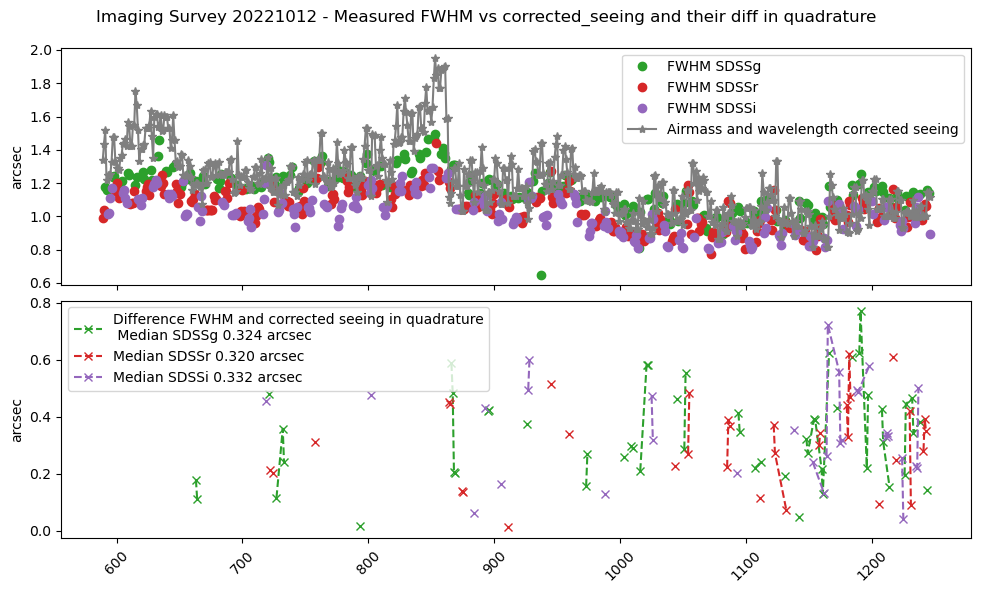

In [10]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, sharex=True)

axs[0].plot(df[df.filter_band=='g'].exposure, df[df.filter_band=='g'].overallFwhm, "C2o", label="FWHM SDSSg")
axs[0].plot(df[df.filter_band=='r'].exposure, df[df.filter_band=='r'].overallFwhm, "C3o", label="FWHM SDSSr")
axs[0].plot(df[df.filter_band=='i'].exposure, df[df.filter_band=='i'].overallFwhm, "C4o", label="FWHM SDSSi")
axs[0].plot(df.exposure, df.corr_dimm_seeing, "C7*-", label="Airmass and wavelength corrected seeing")
axs[0].legend()
axs[0].set_ylabel("arcsec")

df["diff_quadr"] = np.sqrt(((df.overallFwhm**2-df.corr_dimm_seeing**2)))
median_g = df[df.filter_band=='g'].diff_quadr.median()
median_r = df[df.filter_band=='r'].diff_quadr.median()
median_i = df[df.filter_band=='i'].diff_quadr.median()

axs[1].plot(df[df.filter_band=='g'].exposure, df[df.filter_band=='g'].diff_quadr, "C2x--", label=f"Difference FWHM and corrected seeing in quadrature" 
            f"\n Median SDSSg {median_g:0.3f} arcsec")
axs[1].plot(df[df.filter_band=='r'].exposure, df[df.filter_band=='r'].diff_quadr, "C3x--", label=f'Median SDSSr {median_r:0.3f} arcsec')
axs[1].plot(df[df.filter_band=='i'].exposure, df[df.filter_band=='i'].diff_quadr, "C4x--", label = f'Median SDSSi {median_i:0.3f} arcsec')
axs[1].legend()
axs[1].set_ylabel("arcsec")
 
#fig.legend()      

plt.xticks(rotation=45)
fig.suptitle(f"Imaging Survey 20221012 - Measured FWHM vs corrected_seeing and their diff in quadrature")
fig.tight_layout(h_pad=0.5)
fig.patch.set_facecolor('white')   

fig.savefig(f"dxdy.png")
plt.show()

In [ ]:
 np.sqrt((1.2**2-0.8**2))
# df[df.filter_band=='g'].di
# median_r = df[df.filter_band=='r'].diff_quadr.median()
# median_i = df[df.filter_band=='i'].diff_quadr.median()

In [ ]:
df

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
axs[0].plot(df[df.filter_band=='g'].filter_band, df[df.filter_band=='g'].overallFwhm, "C2o", label="FWHM")
axs[0].plot(df[df.filter_band=='r'].filter_band, df[df.filter_band=='r'].overallFwhm, "C3o", label="FWHM")
axs[0].plot(df[df.filter_band=='i'].filter_band, df[df.filter_band=='i'].overallFwhm, "C6o", label="FWHM")

axs[1].plot(df.filter_band, df.diff_quadr, "C3x", label="Residual")

axs[0].set_ylabel("arcsec")


In [ ]:
plt.plot(df[df.filter_band=='g'].corr_dimm_seeing, df[df.filter_band=='g'].overallFwhm, "C2o", label="FWHM")
plt.plot(df[df.filter_band=='r'].corr_dimm_seeing, df[df.filter_band=='r'].overallFwhm, "C3o", label="FWHM")
plt.plot(df[df.filter_band=='i'].corr_dimm_seeing, df[df.filter_band=='i'].overallFwhm, "C4o", label="FWHM")


In [ ]:
plt.plot(df.airmass, df.overallFwhm, "C6o", label="FWHM")


****

# Conclusion

The dome azimuth rotation speed has been examined in 3 dedicated rotation tests of different rotation angles (210, 90 and 30 degrees) and an offline analysis of an observing night, to replicate the dome operations cadence.
In none of these test cases, the azimuth rotational speed has been above the minimum 4 deg/sec speed requirement from LTS-337-030 (Auxiliary Telescope Dome Rotation Requirement). 
